In [1]:
import torch
import numpy as np
import cv2
import os 
import pandas as pd
import albumentations as A
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from albumentations.pytorch.functional import img_to_tensor
from tensorboardX import SummaryWriter
from tqdm.notebook import tqdm

In [2]:
from helpers.config import load_config
from helpers.utils import create_optimizer, AverageMeter
from helpers.losses import miou_round, val_miou_round
from helpers import losses
conf = load_config('helpers/effb5_conf.json') 

In [3]:
#helpers5classes
#helpers

In [4]:
PTH = "Custom Dataset"

In [5]:
train = os.path.join(PTH, 'train/images') 
train_mask = os.path.join(PTH, 'train/masks') 

valid = os.path.join(PTH, 'test/images') 
valid_mask = os.path.join(PTH, 'test/masks') 

# Create transforms

In [6]:
def create_train_transforms():
    #(650,1250) > 512x512 > 512x512 > (650x1250) > 
    
    return A.Compose([
        A.RandomCrop(640, 640, p=1.0),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.OneOf([
            A.MotionBlur(p=.5),
            A.MedianBlur(blur_limit=3, p=.5),
            A.Blur(blur_limit=3, p=.5),
        ], p=1.0),
        A.Transpose(p=0.5),
        A.RandomRotate90(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
            A.GridDistortion(),
            A.OpticalDistortion(distort_limit=2, shift_limit=0.5),
        ], p=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, brightness_by_max=True, always_apply=False, p=0.5)
    ])

def create_val_transforms():
    return A.Compose([
        A.Crop(0,0,640,640, p=1.0)
    ])

# Convert RGB mask to 1D mask

In [7]:
def rgb_to_label(rgb_mask):
    color_to_label = {
        (0,0,0): 0,
        (255,255,255): 1, #(0,255,255)
        (255,0,0): 2,
        (153, 76,0): 3,
        (0,153,0): 4
    }
    height, width, _ = rgb_mask.shape
    label_mask = np.zeros((height, width), dtype = np.uint8)
    
    for color, label in color_to_label.items():
        indices = np.where(np.all(rgb_mask==color, axis=-1))
        #print(indices)
        label_mask[indices] = label
    return label_mask

In [8]:
rgb_mask = cv2.imread("Custom Dataset/train/masks/0000/11.png")

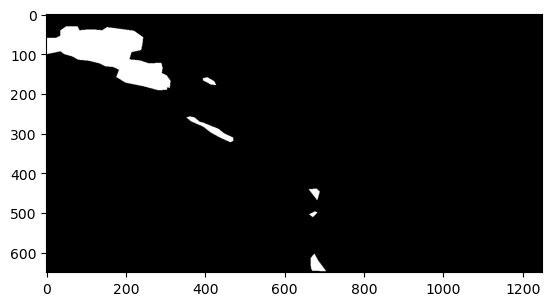

In [9]:
plt.imshow(cv2.cvtColor(rgb_mask, cv2.COLOR_BGR2RGB))

In [10]:
label_mask = rgb_to_label(cv2.cvtColor(rgb_mask, cv2.COLOR_BGR2RGB))

In [11]:
label_mask[label_mask!=1] = 0

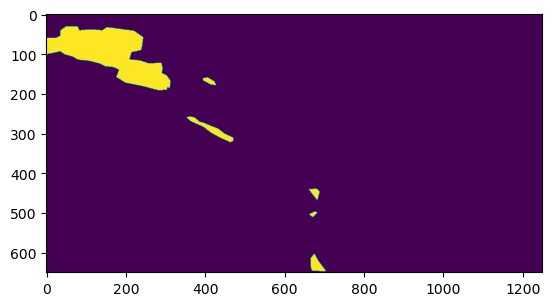

In [12]:
plt.imshow(label_mask)

In [13]:
np.unique(label_mask)

array([0, 1], dtype=uint8)

# Create CSV with common file names

In [14]:
def common_ims(img_pth, mask_pth, mode):
    img_ids = [f'{folder}/{name}' for folder in os.listdir(img_pth) for name in os.listdir(f'{img_pth}/{folder}')]
    mask_ids = [f'{folder}/{name}' for folder in os.listdir(mask_pth) for name in os.listdir(f'{mask_pth}/{folder}')]
    #mask_ids = [s.replace('png', 'jpg') for s in mask_ids]
    
    img_df = pd.DataFrame({'filename': img_ids})
    mask_df = pd.DataFrame({'filename': mask_ids})

    merged_df = pd.merge(img_df, mask_df, on='filename')
    merged_df.to_csv(f'{PTH}/{mode}.csv', index=False)

In [15]:
common_ims(train, train_mask, 'train')
common_ims(valid, valid_mask, 'valid')

In [16]:
train_df = pd.read_csv(f'{PTH}/train.csv')
test_df = pd.read_csv(f'{PTH}/valid.csv')

In [17]:
len(os.listdir(train)), len(os.listdir(train_mask))

(4, 4)

# Dataset

In [18]:
class OilDataset(Dataset):
    def __init__(self, df, mode='train', classes=None, augmentations = None, normalize = None):
        self.df = df['filename']
        self.mode = mode
        self.classes = classes
        self.augmentations = augmentations
        self.normalize = normalize
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = cv2.imread(os.path.join(f'Custom Dataset/{self.mode}/images/', self.df[idx]))
        mask = cv2.imread(os.path.join(f'Custom Dataset/{self.mode}/masks/', self.df[idx]))#.replace('jpg', 'png')))
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = rgb_to_label(mask) # (0,255,255) > 1, .... -> 0, ... -> 2
        
        mask[mask!=1] = 0
        
        if self.augmentations:
            sample = self.augmentations(image=image, mask=mask)
            #image, mask = sample['image'], sample['mask']
        
        mask = np.zeros((self.classes, *sample["mask"].shape[:2]))
        for i in range(self.classes):
            mask[i, sample["mask"] == i] = 1
        
        sample['img_name'] = os.path.join(f'Custom Dataset/{self.mode}/images/', self.df[idx])
        sample['mask_orig'] = sample['mask']
        sample['mask'] = torch.from_numpy(np.ascontiguousarray(mask)).float()
        sample['image'] = img_to_tensor(np.ascontiguousarray(sample['image']), self.normalize)
        return sample
        
        

In [19]:
dataset = OilDataset(train_df, mode='train', classes = 2, augmentations=create_train_transforms(), normalize = conf['input']['normalize'])

In [20]:
dataset[0]['image'].shape, dataset[0]['img_name'], dataset[0]['mask'].shape, dataset[0]['mask_orig'].shape


(torch.Size([3, 640, 640]),
 'Custom Dataset/train/images/0000/0.png',
 torch.Size([2, 640, 640]),
 (640, 640))

# Config

# Train

In [21]:
def train_epoch(current_epoch, loss_functions, model, optimizer, scheduler, train_data_loader, 
                summary_writer, conf):
    losses = AverageMeter()
    mious = AverageMeter()
    iterator = tqdm(train_data_loader)
    model.train()
    if conf["optimizer"]["schedule"]["mode"] == "epoch":
        scheduler.step(current_epoch)
    for i, sample in enumerate(iterator):
        imgs = sample["image"].cuda()
        masks = sample["mask"].cuda().float()
        masks_orig = sample["mask_orig"].cuda().float()
        out_mask = model(imgs)
        with torch.no_grad():
            pred = torch.softmax(out_mask, dim=1)
            argmax = torch.argmax(pred, dim=1)
            ious = miou_round(argmax, masks_orig).item()

        mious.update(ious, imgs.size(0))

        mask_loss = loss_functions["mask_loss"](out_mask, masks.contiguous())
        loss = mask_loss
        losses.update(loss.item(), imgs.size(0))
        iterator.set_description(
            "epoch: {}; lr {:.7f}; Loss ({loss.avg:.4f}); miou ({miou.avg:.4f}); ".format(
                current_epoch, scheduler.get_lr()[-1], loss=losses, miou=mious))
        optimizer.zero_grad()
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        #torch.cuda.synchronize()

        if conf["optimizer"]["schedule"]["mode"] in ("step", "poly"):
            scheduler.step(i + current_epoch * len(train_data_loader))
   
    for idx, param_group in enumerate(optimizer.param_groups):
        lr = param_group['lr']
        summary_writer.add_scalar('group{}/lr'.format(idx), float(lr), global_step=current_epoch)
    summary_writer.add_scalar('train/loss', float(losses.avg), global_step=current_epoch)

In [22]:
def validate(net, data_loader, predictions_dir):
    os.makedirs(predictions_dir, exist_ok=True)
    preds_dir = predictions_dir + "/predictions"
    os.makedirs(preds_dir, exist_ok=True)
    mious = []
    oil_class_iou = []
    with torch.no_grad():
        for sample in tqdm(data_loader):
            imgs = sample["image"].cuda().float()
            mask_orig = sample["mask_orig"].cuda().float()

            output = net(imgs)
            pred = torch.softmax(output, dim=1)
            argmax = torch.argmax(pred, dim=1)

            for i in range(output.shape[0]):
                d, ious = val_miou_round(argmax, mask_orig)
                
                mious.append(d.item())
                oil_class_iou.append(ious[1].item())
                cv2.imwrite(os.path.join(preds_dir, "test_" + sample['img_name'][i].split('/')[-1].replace('.png', '') + "_prediction.png"),
                            argmax[i].cpu().numpy().astype(np.uint8) * 64)

                cv2.imwrite(os.path.join(preds_dir, "test_" + sample['img_name'][i].split('/')[-1].replace('.png', '') + "_mask_orig.png"),
                            mask_orig[i].cpu().numpy().astype(np.uint8) * 64)
    print(np.mean(oil_class_iou))
    return np.mean(mious)
def evaluate_val(output_dir, data_val, miou_best, model, snapshot_name, current_epoch, optimizer, summary_writer,
                 predictions_dir):
    print("Test phase")
    model = model.eval()
    miou = validate(model, data_loader=data_val, predictions_dir=predictions_dir)
    summary_writer.add_scalar('val/miou', float(miou), global_step=current_epoch)
    if miou > miou_best:
        if output_dir is not None:
            torch.save({
                'epoch': current_epoch + 1,
                'state_dict': model.state_dict(),
                'miou_best': miou,

            }, output_dir +'/' + snapshot_name + "_best_miou.pt")
        miou_best = miou
    torch.save({
        'epoch': current_epoch + 1,
        'state_dict': model.state_dict(),
        'miou_best': miou_best,
    }, output_dir + '/'+ snapshot_name + "_last.pt")
    print("miou: {}, miou_best: {}".format(miou, miou_best))
    return miou_best

In [23]:
import segmentation_models_pytorch as smp



# 1st method

In [24]:
#model = smp.Unet(encoder_name='efficientnet-b5', classes=2) # effnet on ImageNet 1000 classes

# 2nd method

In [73]:
model = smp.Unet(encoder_name='efficientnet-b7', classes=2, encoder_weights=None) # effnet on ImageNet 1000 classes
checkpoint = torch.load('models/Kaspi/Efficientnet-b7/2/segment_efficientnet-b7_efficientnet-b7_best_miou.pt', map_location='cpu') # 5 class Segmentation model on greece dataset
state_dict = checkpoint['state_dict']
model.load_state_dict(state_dict, strict=False)
#model.segmentation_head[0] = torch.nn.Conv2d(16, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

<All keys matched successfully>

In [74]:
print('Epochs',checkpoint['epoch'])
print('MIoU Best', checkpoint['miou_best'])

Epochs 2
MIoU Best 0.945875230588411


In [26]:
model

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePaddi

In [27]:
model = model.cuda()

In [28]:
mask_loss_function = losses.__dict__[conf["mask_loss"]["type"]](**conf["mask_loss"]["params"]).cuda()
loss_functions = {"mask_loss": mask_loss_function}
optimizer, scheduler = create_optimizer(conf['optimizer'], model)

miou_best = 0
start_epoch = 0
batch_size = conf['optimizer']['batch_size']
#print(train_lst)
data_train = OilDataset(train_df,
                        mode='train', 
                        classes = 2, 
                        augmentations=create_train_transforms(), 
                        normalize = conf['input']['normalize'])
data_val = OilDataset(test_df,
                        mode='test', 
                        classes = 2, 
                        augmentations=create_val_transforms(), 
                        normalize = conf['input']['normalize'])
train_sampler = None

In [29]:
train_data_loader = DataLoader(data_train, batch_size=batch_size, 
                                   shuffle=train_sampler is None, sampler=train_sampler, pin_memory=False,
                                   drop_last=True) #num_workers=8,
#print(data_train.__getitem__(1)['image'].shape)
#print(data_train.__getitem__(1)['mask'].shape)
val_batch_size = 1
val_data_loader = DataLoader(data_val, batch_size=val_batch_size,  shuffle=False,
                             pin_memory=False) #num_workers=8,

In [30]:
#!mkdir predictions

In [31]:
output_dir = 'outputs'
predictions_path = 'predictions'

In [32]:
logdir = 'logs'
summary_writer = SummaryWriter(logdir + '/' + 'segment_' + conf['encoder'])

In [33]:
start_epoch = 0
current_epoch=0

In [34]:
snapshot_name = "{}{}_{}".format('segment_', conf['network'], conf['encoder'])

In [35]:
for epoch in range(start_epoch, conf['optimizer']['schedule']['epochs']):
        if train_sampler:
            train_sampler.set_epoch(epoch)

        model_encoder_stages = model.encoder
        model_encoder_stages.train()
        for p in model_encoder_stages.parameters():
            p.requires_grad = True
        train_epoch(current_epoch, loss_functions, model, 
                    optimizer, scheduler, train_data_loader, summary_writer, conf)

        model = model.eval()
        
        torch.save({
            'epoch': current_epoch + 1,
            'state_dict': model.state_dict(),
            'miou_best': miou_best,
        }, output_dir + '/' + snapshot_name + "_last")
        preds_dir = os.path.join(predictions_path, snapshot_name)
        miou_best = evaluate_val(output_dir, val_data_loader, miou_best, model,
                                 snapshot_name=snapshot_name,
                                 current_epoch=current_epoch,
                                 optimizer=optimizer, summary_writer=summary_writer,
                                 predictions_dir=preds_dir)
        current_epoch += 1


  0%|          | 0/111 [00:00<?, ?it/s]

C:\Users\spark lab\anaconda3\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
C:\Users\spark lab\anaconda3\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable t

Test phase


  0%|          | 0/76 [00:00<?, ?it/s]

0.8955994660085637
miou: 0.9455939221538996, miou_best: 0.9455939221538996


  0%|          | 0/111 [00:00<?, ?it/s]

Test phase


  0%|          | 0/76 [00:00<?, ?it/s]

0.8947412991662089
miou: 0.9451450674157393, miou_best: 0.9455939221538996


  0%|          | 0/111 [00:00<?, ?it/s]

Test phase


  0%|          | 0/76 [00:00<?, ?it/s]

0.8947412991662089
miou: 0.9451450674157393, miou_best: 0.9455939221538996


  0%|          | 0/111 [00:00<?, ?it/s]

Test phase


  0%|          | 0/76 [00:00<?, ?it/s]

0.8947412991662089
miou: 0.9451450674157393, miou_best: 0.9455939221538996


  0%|          | 0/111 [00:00<?, ?it/s]

Test phase


  0%|          | 0/76 [00:00<?, ?it/s]

0.8947412991662089
miou: 0.9451450674157393, miou_best: 0.9455939221538996


  0%|          | 0/111 [00:00<?, ?it/s]

Test phase


  0%|          | 0/76 [00:00<?, ?it/s]

0.8947412991662089
miou: 0.9451450674157393, miou_best: 0.9455939221538996


  0%|          | 0/111 [00:00<?, ?it/s]

Test phase


  0%|          | 0/76 [00:00<?, ?it/s]

0.8947412991662089
miou: 0.9451450674157393, miou_best: 0.9455939221538996


  0%|          | 0/111 [00:00<?, ?it/s]

Test phase


  0%|          | 0/76 [00:00<?, ?it/s]

0.8947412991662089
miou: 0.9451450674157393, miou_best: 0.9455939221538996


  0%|          | 0/111 [00:00<?, ?it/s]

Test phase


  0%|          | 0/76 [00:00<?, ?it/s]

0.8947412991662089
miou: 0.9451450674157393, miou_best: 0.9455939221538996


  0%|          | 0/111 [00:00<?, ?it/s]

Test phase


  0%|          | 0/76 [00:00<?, ?it/s]

0.8947412991662089
miou: 0.9451450674157393, miou_best: 0.9455939221538996


  0%|          | 0/111 [00:00<?, ?it/s]

Test phase


  0%|          | 0/76 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
#w_new = w_old - 0.0003*(dE/dw_old)  oil_spill pretrained model 0.01 > 0.00001

# 1d to RGB

In [35]:
import numpy as np
import cv2

def convert_mask(mask):
   
    color_mappings = {
        0: (0, 0, 0),
        1: (0, 255, 255),
        2: (255, 0, 0),
        3: (153, 76, 0),
        4: (0, 153, 0)
    }

   
    height, width= mask.shape
    rgb_mask = np.zeros((height, width, 3), dtype=np.uint8)

   
    for class_idx, color in color_mappings.items():
        class_mask = (mask == class_idx)
        rgb_mask[class_mask] = color

    
    return rgb_mask


In [50]:
img1 = cv2.imread('predictions/segment_resnet34_resnet34/predictions/test_42_308,18_108_1.jpg_mask_orig.png')
img2 = cv2.imread('predictions/segment_resnet34_resnet34/predictions/test_42_308,18_108_1.jpg_prediction.png')

In [51]:
img1 = img1/64
img2 = img2/64

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


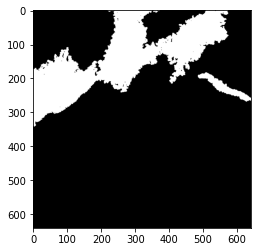

In [52]:
plt.imshow(img1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


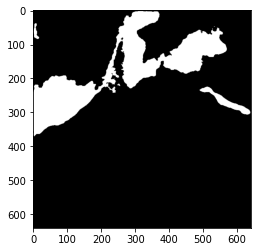

In [53]:
plt.imshow(img2)

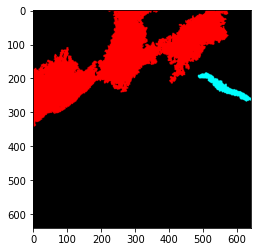

In [54]:
plt.imshow(convert_mask(img1[:,:,1]))

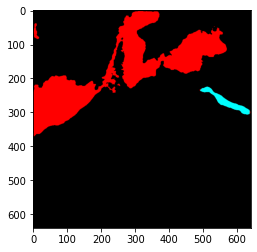

In [55]:
plt.imshow(convert_mask(img2[:,:,1]))

In [113]:
img[:,:,1].shape

(640, 640)

In [ ]:
# 650x1250 > 